## Re-run Modeling spawning salmon with PyMC v4
Source: https://github.com/fonnesbeck/gp_regression/blob/master/notebooks/spawning_salmon.ipynb

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

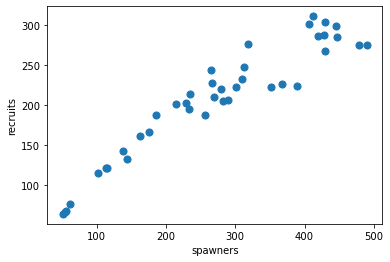

In [2]:
salmon_data = pd.read_table('../data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

In [3]:
x, y = salmon_data[['spawners', 'recruits']].values.T

### Gaussian Process

In [4]:
with pm.Model() as gp_salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)   

#### Using trace

In [5]:
with gp_salmon_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ρ, η, σ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 27 seconds.


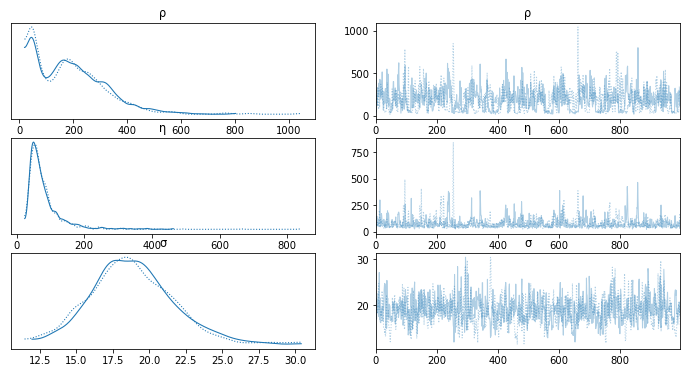

In [6]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [7]:
X_pred = np.linspace(0, 500, 100)
with gp_salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred.reshape(-1, 1))
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=['salmon_pred'], 
                                                       random_seed=42)

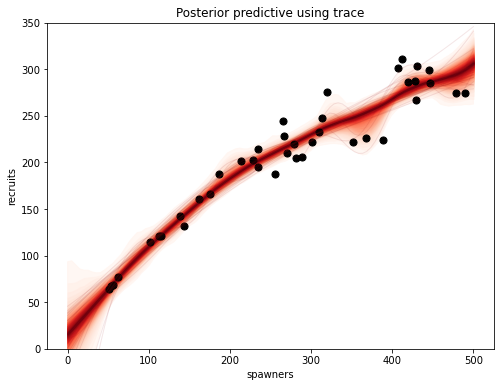

In [8]:
# Plot posterior predictive with X_pred using trace
from pymc.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples.posterior_predictive['salmon_pred'].sel(chain=1), X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);
plt.title("Posterior predictive using trace");

#### Using find MAP

In [9]:
with gp_salmon_model:
    mp = pm.find_MAP()
    salmon_pred_map = recruit_gp.conditional("salmon_pred_map", X_pred.reshape(-1, 1))
    salmon_samples = pm.sample_posterior_predictive([mp], samples=1000, 
                                                    var_names=['salmon_pred_map'], keep_size=False)

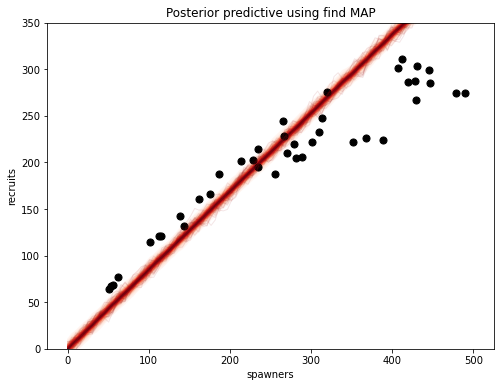

In [10]:
# THIS SEEMS WRONG!!!
from pymc.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, salmon_samples.posterior_predictive['salmon_pred_map'].sel(chain=0), X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350)
plt.title("Posterior predictive using find MAP");